In [10]:
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import h5py
import os
import tqdm
import scipy
from scipy import signal
from scipy.signal import resample
from tqdm import tnrange
import seaborn as sns
from scipy.stats import norm,entropy,linregress
from scipy.optimize import minimize, curve_fit
from scipy.io import savemat
import multiprocess as mp
from multiprocess import Pool
import sys
import warnings
warnings.filterwarnings('ignore')
sns.set_context('poster', font_scale=1.1)
cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
modulename = 'multiprocess'

mpl.rcParams['svg.fonttype'] = 'none'
sns.set_context('poster', font_scale=1.1)
path = os.getcwd() + '/Session/'

Loading a session_animalname_date_sessionnum.pickle file gives a single-element list containing a dictionary
============================================================================================================

Information about trial outcomes
---------------------------------------------------------------------------------------------------------------------------------------

**num_trials**: number of trials recorded  

**high_trials**: boolean saying if the trial had a high number of pulses (above boundary) or not  

**low_trials**: the opposite of high_trials  

**high_choice**: boolean saying if animal chose the 'high side' or not  

**low_choice**: boolean saying if animal chose the 'low side' or not

**correct_trials**: boolean saying if the animal got the trial correctly or not.  (high_choice==True & high_trials==True and the opposite)

**failure_trials**: Opposite of correct trials.  

**idle_trials**: if True, animal didn't make any binary choice in that trial  

**performance**: Correct trials/Total trials in the session  


**Information about session parameters**
---------------------------------------------------------------------------------------------------------------------------------------

**type**: Whether high and low trials were delivered in blocks (usually true for training phase) or randomly (once animals learnt the task).  

**lick training**: When True, odors are not delivered. This is only used at the beggining of the training when animals are learning lick port location.  

**free_drop**: if True, water drop will delivered to the correct side independently of animal action. Only used at the beggining of training.  

**high_count**: lambda of the poisson distribution used for generating the trials with high number of pulses.  

**low_count**: lambda of the poisson distribution used for generating the trials with low number of pulses

**pulse_time_ms**: duration of the individual odor pulses in ms
 
**refract_time**: duration (in ms) of the waiting period before the sampling period of a trial  

**delay_time**: duration of the sampling period (period in which odor pulses are delivered)  

**go_time**: duration of the period in which the animal has to lick (in ms)  


**Information about odor and sniffing**
---------------------------------------------------------------------------------------------------------------------------------------

**trial_odor**: array with len equal to delay_time containing the time course of the commands to solenoid valves for odor delivery. 0 =  no odor, 100 = odor on. When two or more consecutive pulses overlaps, that is displayed as 100 multiples  

**trial_pre_breath**: an array containing the sniffing during the refractory period.  

**trial_breath**: an array containing the sniffing during delay_time(sampling period)+go_time. 


**Other accesory information**
---------------------------------------------------------------------------------------------------------------------------------------

**animal**: ID of the animal  

**year**: year of the session  

**month**: month of the session  

**day**: day date of the session  

**session_id**: number identifying the she specific session for when multiple sessions are conducted on a day  

In [8]:
session_fname = path + 'session_' + 'Banner_20220305_3.pickle' #remember to change the path to where your file is
if os.path.isfile(session_fname):
    with open(session_fname,'rb') as handle:
        session_list = pickle.load(handle)
        session = session_list[0]

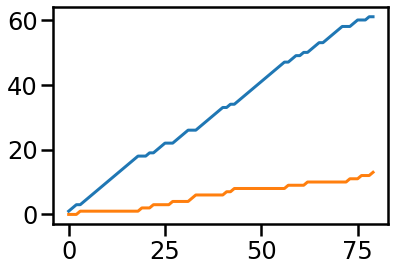

In [75]:
#Plotting correct and error trials on a session.

plt.plot(session_list[0]['correct_trials'].cumsum())
plt.plot(session_list[0]['failure_trials'].cumsum())

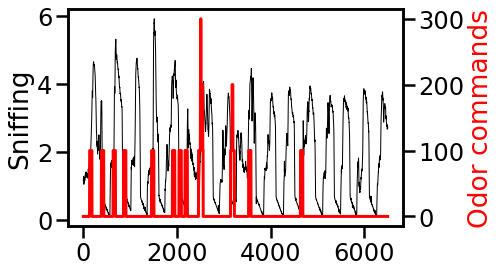

In [83]:
# Plotting breathing an odor in a single trial.

fig, ax1 = plt.subplots()

# Plot the first variable on the left y-axis
ax1.plot(session_list[0]['trial_breath'][2], '-k', linewidth=1)
ax1.set_ylabel('Sniffing', color='k')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second variable on the right y-axis
ax2.plot(session_list[0]['trial_odor'][2], 'r-')
ax2.set_ylabel('Odor commands', color='r')

plt.show()

# plt.plot(session_list[0]['trial_breath'][2])
# plt.plot(session_list[0]['trial_odor'][2])
# plt.show()

Loading a cell_animalname_date_sessionnum.pickle file gives a list, with the length=recorded units. For each element of the list there is a dictionary
============================================================================================================

Information about the specific neuron
---------------------------------------------------------------------------------------------------------------------------------------

**cell_id**: id of the neuron/unit  

**ks_id**: id of the neuron based on kilosort  

**sample_rate**: sampling rate used for the acquisition of neural recordings.

**spike_times**: timing of the spikes during the recording window.  Events can happen in a window which goes from 0 (500 ms after sampling window started) to 135000 (the end of the sampling window). Remember that sampling rate is 30000 Hz

**firing_rate**: not sure how this firing rate calculation was done, so I don't use it.



**Information about session parameters**
---------------------------------------------------------------------------------------------------------------------------------------

**num_trials**: number of trials recorded in the session. 

**delay_time**: duration of the sampling period (period in which odor pulses are delivered)  

**cut_delay_time**: duration of the part of delay time that was discarded of the analysis (the initial 0.5 s of the sampling periods; spikes were not taken into account due to artifacts)

**full_delay_time**: duration of the part of sampling period for which spikes are actually considered (4.5 s)


**Other accesory information**
---------------------------------------------------------------------------------------------------------------------------------------

**year**: year of the session  

**month**: month of the session  

**day**: day date of the session  

**session**: number identifying the she specific session for when multiple sessions are conducted on a day  

In [54]:
new_path = os.getcwd() + '/HW_Data/pack_data_new/' #remember to change the path to where your file is
cell_fname = new_path + 'cell_' + 'Bengal_20190430_0.pickle'
if os.path.isfile(cell_fname):
    print('pepe')
    with open(cell_fname,'rb') as handle:
        cell_list = pickle.load(handle)
        cell = cell_list[0]

pepe


In [101]:
def convert_to_numpy_arrays(data):
    if isinstance(data, np.ndarray):
        return data
    elif isinstance(data, list):
        return np.array([convert_to_numpy_arrays(item) for item in data])
    else:
        return np.array([data])

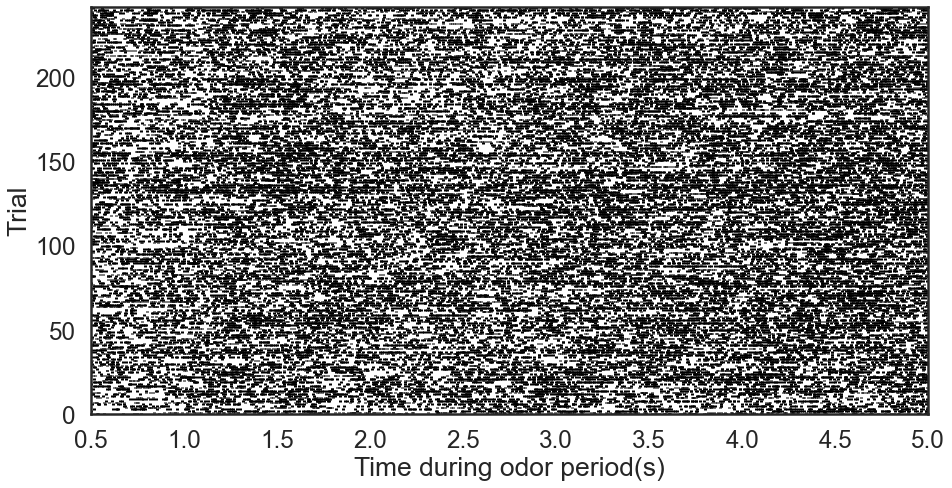

In [109]:
# Generating raster plot of a single neuron across all trials on a session

icell = 8
cell = cell_list[icell]

num_trials = cell['num_trials']
#non_idle_trial_ids = np.argwhere(non_idle_trials).squeeze()
sp_times = np.array(cell['spike_times'])[:num_trials]#[non_idle_trials]

spike_times = convert_to_numpy_arrays(sp_times) 
max_counts = 0
for i in range(len(spike_times)):
    max_counts = max(max_counts,len(spike_times[i]))
    #print(max_counts)

spike_table =np.zeros((len(spike_times),max_counts))
#rank_ind = np.argsort(trial_cum_odor)
for i in range(len(spike_times)):
    spike_time = spike_times[i]
    spike_table[i,:len(spike_time)] = spike_time/30000 + 0.5


sns.set_style('white')
fig = plt.figure(figsize=(15,7.5))
plt.eventplot(spike_table,color='black')
plt.xlim(0.5,5)
plt.ylim(0,242)
plt.xlabel('Time during odor period(s)')
plt.ylabel('Trial')
plt.show()

Now, going to the codes and kernels data coming from the DUNL analysis of the ephys and behavior
================================================================================================

In [4]:
codepath = os.getcwd() + '/Bahareh/'


dat = np.load(codepath+'Bengal_20190508_0_data_all.npy', allow_pickle=True)
data = dat.tolist() #Maybe this conversion to list is not necessary but I remember having some issues without it.
print(data.keys())

dict_keys(['y_0', 'Hx_0', 'a_0', 'rate_hat_0', 'x_est_0', 'kernel_est_0', 'x', 'high_choice', 'norm_phase_hist_0', 'y_1', 'Hx_1', 'a_1', 'rate_hat_1', 'x_est_1', 'kernel_est_1', 'norm_phase_hist_1', 'y_2', 'Hx_2', 'a_2', 'rate_hat_2', 'x_est_2', 'kernel_est_2', 'norm_phase_hist_2', 'y_3', 'Hx_3', 'a_3', 'rate_hat_3', 'x_est_3', 'kernel_est_3', 'norm_phase_hist_3', 'y_4', 'Hx_4', 'a_4', 'rate_hat_4', 'x_est_4', 'kernel_est_4', 'norm_phase_hist_4', 'y_5', 'Hx_5', 'a_5', 'rate_hat_5', 'x_est_5', 'kernel_est_5', 'norm_phase_hist_5', 'y_6', 'Hx_6', 'a_6', 'rate_hat_6', 'x_est_6', 'kernel_est_6', 'norm_phase_hist_6', 'y_7', 'Hx_7', 'a_7', 'rate_hat_7', 'x_est_7', 'kernel_est_7', 'norm_phase_hist_7', 'y_8', 'Hx_8', 'a_8', 'rate_hat_8', 'x_est_8', 'kernel_est_8', 'norm_phase_hist_8', 'y_9', 'Hx_9', 'a_9', 'rate_hat_9', 'x_est_9', 'kernel_est_9', 'norm_phase_hist_9', 'y_10', 'Hx_10', 'a_10', 'rate_hat_10', 'x_est_10', 'kernel_est_10', 'norm_phase_hist_10', 'y_11', 'Hx_11', 'a_11', 'rate_hat_11'

Loading the data_all.npy file provides a single dictionary with a set of parameters that are repeated for each recorded neuron, indicated by the _0, 1, 2, etc., at the end of the variable.

According to Bahareh, these variables represent:

y_{#neuron}: spike counts from neuron #

Hx_{#neuron}: you can skipa_{#neuron}: baseline

rate_hat_{#neuron}: estimated rate for neuron

x_est_{#neuron}: This is the code estimate from the trial. This is at the 50 ms binned resolution from each trial.

kernel_est_{# neuron}:  length of kernel which is 20 samples, with 50 ms res, this is 1 s

x: this is the odor onset in the 50 ms bin resolution

high_choice: a flag for whether the trial was high or low odor count.

'norm_phase_hist_{#neuron}': This a phase histogram weighted by the code amplitudes

You can also get some of this information from the other files, the ones called _kernels.npy, codes_stacked_trial.npy, phase_weighted_by_codes.npy, but I found easier just to load the data_all, since it has it all.

In [17]:
test = data['norm_phase_hist_0'] #This contains a vector of length 36, so the phase variations on code amplitude seem to be binned in 36 bins

#This is the set of transformations that Hao used to do with the norm_phase_hist data coming from Bahareh's analysis.
#Not completely sure if this is fully correct, but it's the way he was using

print(test)
X_upsampled = resample(test,360,axis=0)
print(X_upsampled)
X_rolled = np.roll(X_upsampled,50,axis=0)
print(X_rolled)
X_resampled = resample(X_rolled,14,axis=0)
print(X_resampled)
X_norm = X_resampled/X_resampled.max(axis=0).reshape(-1,1)
print(X_norm)
# X_norm_nan_removed = X_norm[~np.isnan(X_norm).any(axis=1)]
# Xnorm.append(X_norm_nan_removed)

[3.83371647 3.39179613 3.85967522 3.43521504 2.95365215 3.44484086
 2.10109285 3.20157919 2.92652157 2.45061273 3.04253493 2.02273904
 2.37888705 2.72021201 1.85539167 2.45285181 1.81114638 1.53417916
 1.92263254 2.24048173 1.88913368 2.8676058  1.63472845 1.96041271
 1.81179851 2.2206248  2.62713931 2.82395646 2.88625463 3.24073377
 3.06376153 3.49217428 2.91778967 3.61085397 2.28370337 3.7195825 ]
[3.83371647 3.72030143 3.61269216 3.51724129 3.43878125 3.38046062
 3.34372976 3.32846117 3.33317893 3.35536374 3.39179613 3.43890049
 3.49305638 3.55085076 3.60925375 3.66571144 3.71815949 3.76497053
 3.80485583 3.83674584 3.85967522 3.87269603 3.87483735 3.86512234
 3.84264468 3.80669732 3.75693798 3.6935689  3.61750468 3.53050039
 3.43521504 3.33519051 3.23473462 3.1387065  3.05221404 2.98024298
 2.92724708 2.89673499 2.89089319 2.91028384 2.95365215 3.01787013
 3.09803245 3.18770719 3.27933043 3.36471985 3.43567082 3.48458916
 3.50510974 3.49264865 3.44484086 3.36182272 3.24633075 3.103